In [17]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

## Get data

In [2]:
craft_res_dir = "/Users/jasonli/Desktop/BU/Junior/Spring2021/CS791/sandbox/test_models/CRAFT-pytorch-master/result"

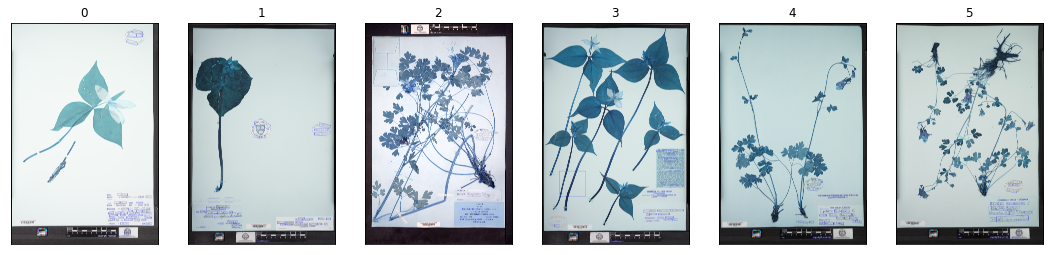

In [50]:
txt_files = []
imgs = []

for fname in os.listdir(craft_res_dir):
    if ".jpg" in fname and "mask" not in fname:
        imgs.append(cv2.imread(os.path.join(craft_res_dir, fname)))

        txt_files.append(open(os.path.join(craft_res_dir, fname[:len(fname)-3]+"txt"),"r").read().split("\n"))

n_imgs = len(imgs)

fig, axes = plt.subplots(1, n_imgs)
fig.set_size_inches(18.5, 10.5)
# plt.imshow(imgs[0], cmap="gray")
for i, img in enumerate(imgs):
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(i)
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

True

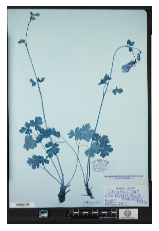

In [129]:
this_img = 4
plt.imshow(imgs[this_img])
plt.axis('off')
cv2.imwrite("img.png", imgs[this_img])

## Helper funcs

In [161]:
def union(box):
    xcoords = [pt[0] for pt in box]
    ycoords = [pt[1] for pt in box]
    
    x = min(xcoords)
    y = min(ycoords)
    
    w = max(xcoords) - x
    h = max(ycoords) - y
    
    return (x, y, w, h)

def has_overlap2(b1,b2):
    l1 = [float('inf'), float('inf')]
    r1 = [float('-inf'), float('-inf')]
    l2 = [float('inf'), float('inf')]
    r2 = [float('-inf'), float('-inf')]

    for pt in b1:
        if pt[0]<l1[0] and pt[1]<l1[1]:
            l1[0]=pt[0]
            l1[1]=pt[1]
        elif pt[0]>r1[0] and pt[1]>r1[1]:
            r1[0]=pt[0]
            r1[1]=pt[1]
    
    for pt in b2:
        if pt[0]<l2[0] and pt[1]<l2[1]:
            l2[0]=pt[0]
            l2[1]=pt[1]
        elif pt[0]>r1[0] and pt[1]>r2[1]:
            r2[0]=pt[0]
            r2[1]=pt[1]
            
#     # e.g. in quadrants 2 and 4
#     if (r1[0]<l2[0] and r1[1]<l2[1]) or (r2[0]<l1[0] and r2[1]<l1[1]):
#         return False
    print(l1, r1)
    print(l2, r2)


    if r1[0]<l2[0] or r2[0]<l1[0] or r1[1]<l2[1] or r2[1]<l1[1]:
        return None

#     else:
    newL = [min(l1[0],l2[0]), min(l1[1],l2[1])]
    newR = [max(r1[0],r2[0]), max(r1[1],r2[1])]
    return newL, newR

#         return min(l1[0],l2[0]), min(l1[1],l2[1]), max(r1[0],r2[0])-min(l1[0],l2[0]), max(r1[1],r2[1])-min(l1[1],l2[1]) # x, y, w, h
    
def has_overlap(b1,b2):
    # boxes inputed as [[top left], [top right], [bottom right], [bottom left]]
    tl1, tr1, br1, bl1 = b1
    tl2, tr2, br2, bl2 = b2
    overlap = False
#     print(tl1, tr1, br1, bl1)
#     print(tl2, tr2, br2, bl2)


    if tl1[0]>=bl2[0] and tl1[0]<=br2[0] and tl1[1]>=tr2[1] and tl1[1]<=br2[1]: # if top left corner of 1 in 2
        overlap = True
    elif tr1[0]>=bl2[0] and tr1[0]<=br2[0] and tr1[1]>=tr2[1] and tr1[1]<=br2[1]: # if top right corner of 1 in 2
        overlap = True
    elif bl1[0]>=tl2[0] and bl1[0]<=tr2[0] and bl1[1]>=tr2[1] and bl1[1]<=br2[1]: # if bottom left corner of 1 in 2
        overlap = True
    elif br1[0]>=tl2[0] and br1[0]<=tr2[0] and br1[1]>=tr2[1] and br1[1]<=br2[1]: # if bottom right corner of 1 in 2
        overlap = True

    if overlap:
        newTL = [min(tl1[0],tl2[0]),min(tl1[1],tl2[1])]
        newTR = [max(tr1[0],tr2[0]),min(tr1[1],tr2[1])]
        newBL = [min(bl1[0],bl2[0]),max(bl1[1],bl2[1])]
        newBR = [max(br1[0],br2[0]),max(br1[1],br2[1])]
        return [newTL,newTR,newBR,newBL]
        
        
        
        

In [162]:
testb1=[[0,0], [2,0], [2,2], [0,2]]
testb2=[[1,1], [3,1], [3,3], [1,3]]


asdf = has_overlap(testb1, testb2)
print(asdf)

[[0, 0], [3, 0], [3, 3], [0, 3]]


## Process CRAFT output

In [52]:
temp1 = imgs[this_img].copy()
temp1.shape

(5616, 3744, 3)

In [84]:
temptxt = txt_files[this_img].copy()[:-1]
temptxt

['2344,3937,2628,4003,2610,4080,2326,4015',
 '2227,4093,2579,4080,2581,4141,2229,4154',
 '2230,4173,2514,4203,2506,4277,2222,4247',
 '2825,4369,2878,4369,2878,4405,2825,4405',
 '2895,4369,3044,4369,3044,4405,2895,4405',
 '3062,4369,3264,4369,3264,4405,3062,4405',
 '3281,4369,3510,4369,3510,4396,3281,4396',
 '2518,4378,2676,4378,2676,4405,2518,4405',
 '2676,4378,2808,4378,2808,4405,2676,4405',
 '2895,4422,3027,4422,3027,4448,2895,4448',
 '3036,4422,3176,4422,3176,4448,3036,4448',
 '2764,4431,2886,4431,2886,4457,2764,4457',
 '3115,4677,3308,4677,3308,4712,3115,4712',
 '2808,4685,2913,4685,2913,4712,2808,4712',
 '2930,4685,3053,4685,3053,4712,2930,4712',
 '2562,4729,2764,4729,2764,4835,2562,4835',
 '2922,4747,3044,4747,3044,4817,2922,4817',
 '3097,4756,3316,4756,3316,4817,3097,4817',
 '2764,4764,2878,4764,2878,4843,2764,4843',
 '3053,4843,3422,4843,3422,4913,3053,4913',
 '2799,4852,3009,4852,3009,4922,2799,4922',
 '2544,4870,2720,4870,2720,4914,2544,4914',
 '3291,4917,3513,4952,3500,5032,

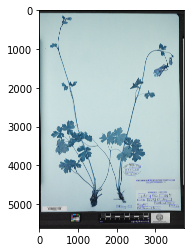

In [54]:
plt.imshow(temp1)

In [177]:
## Method for EXPANDING BOXES

def expandBoxes(img_txt, xmarg=20,ymarg=40):
    
    boxes = []

    for i,box in enumerate(img_txt):
        coord = []
        temppt = []

        xcoords = []
        ycoords = []

        for j,val in enumerate(img_txt[i].split(",")):
            val = int(val)
            if j%2==0:
                temppt = []
                xcoords.append(val)

            temppt.append(val)

            if j%2!=0:
                coord.append(temppt)
                ycoords.append(val)

        # with the original box, expand it
        xavg = np.mean(xcoords)
        yavg = np.mean(ycoords)
        for k,(x,y) in enumerate(coord):
            if x>xavg:
                coord[k][0]+=xmarg
            else:
                coord[k][0]-=xmarg

            if y>yavg:
                coord[k][1]+=ymarg
            else:
                coord[k][1]-=ymarg

        boxes.append(coord)
        
    return boxes

In [178]:
boxes = expandBoxes(temptxt)

[[[2324, 3897], [2648, 3963], [2630, 4120], [2306, 4055]],
 [[2207, 4053], [2599, 4040], [2601, 4181], [2209, 4194]],
 [[2210, 4133], [2534, 4163], [2526, 4317], [2202, 4287]],
 [[2805, 4329], [2898, 4329], [2898, 4445], [2805, 4445]],
 [[2875, 4329], [3064, 4329], [3064, 4445], [2875, 4445]],
 [[3042, 4329], [3284, 4329], [3284, 4445], [3042, 4445]],
 [[3261, 4329], [3530, 4329], [3530, 4436], [3261, 4436]],
 [[2498, 4338], [2696, 4338], [2696, 4445], [2498, 4445]],
 [[2656, 4338], [2828, 4338], [2828, 4445], [2656, 4445]],
 [[2875, 4382], [3047, 4382], [3047, 4488], [2875, 4488]],
 [[3016, 4382], [3196, 4382], [3196, 4488], [3016, 4488]],
 [[2744, 4391], [2906, 4391], [2906, 4497], [2744, 4497]],
 [[3095, 4637], [3328, 4637], [3328, 4752], [3095, 4752]],
 [[2788, 4645], [2933, 4645], [2933, 4752], [2788, 4752]],
 [[2910, 4645], [3073, 4645], [3073, 4752], [2910, 4752]],
 [[2542, 4689], [2784, 4689], [2784, 4875], [2542, 4875]],
 [[2902, 4707], [3064, 4707], [3064, 4857], [2902, 4857]

(-0.5, 3743.5, 5615.5, -0.5)

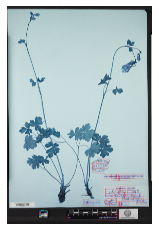

In [179]:
## Draw expanded boxes 
temp1 = imgs[this_img].copy()
boxes_exp = expandBoxes(temptxt)

for box in boxes_exp:
    cv2.drawContours(temp1,np.int0([box]),0,(255,0,0),2)
plt.imshow(temp1)
plt.axis('off')
# cv2.imwrite("expandedboxes.png", temp1)

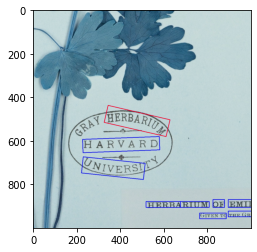

In [77]:
## IGNORE
x=2326
y=3937
w=2628-x
h=4080-y
temp1 = imgs[this_img].copy()
# cv2.rectangle(temp1,(x,y),(x+w,y+h),(255, 0,0),10)
cv2.drawContours(temp1,np.int0([coord1]),0,(255,0,0),2)
plt.imshow(temp1[3500:4500,2000:3000])
# rect = cv2.minAreaRect(c)
# box = cv2.boxPoints(rect)
# box = np.int0(box)
# cv2.drawContours(temp1,coord1,0,(0,191,255),2)

In [121]:
## IGNORE
dists = [box[0][0]*box[0][1] for box in boxes]
dists = np.argsort(dists)
boxes2 = np.zeros_like(boxes)
for i,sorted_idx in enumerate(dists):
    boxes2[sorted_idx]=boxes[i]

In [168]:
## COMBINE THE BOXES
# temp1 = imgs[this_img].copy()
count = len(boxes)
newboxes = []

for box in boxes:
    added = False
    
    for i, newb in enumerate(newboxes):
        overlap = has_overlap(box,newb)
        if overlap != None:
            newboxes[i] = overlap
            added = True
            
    if not added:
        newboxes.append(box)
    
#     cv2.drawContours(temp1,np.int0([box]),0,(255,0,0),2)
# plt.imshow(temp1)
# plt.axis('off')

In [169]:
newboxes

[[[2207, 3897], [2648, 3963], [2630, 4317], [2202, 4287]],
 [[2656, 4329], [3530, 4329], [3530, 4497], [2656, 4497]],
 [[2498, 4338], [2906, 4338], [2906, 4497], [2498, 4497]],
 [[3095, 4637], [3328, 4637], [3328, 4752], [3095, 4752]],
 [[2524, 4645], [3640, 4645], [3634, 5184], [2524, 5173]],
 [[2524, 4689], [3284, 4689], [3284, 5184], [2514, 5173]],
 [[3077, 4716], [3336, 4716], [3336, 4857], [3077, 4857]],
 [[1971, 4988], [2274, 4988], [2265, 5152], [1971, 5120]],
 [[2062, 4992], [2424, 4996], [2424, 5152], [2053, 5129]],
 [[2349, 5312], [2880, 5312], [2880, 5524], [2349, 5524]],
 [[1559, 5400], [1678, 5400], [1678, 5506], [1559, 5506]]]

(-0.5, 3743.5, 5615.5, -0.5)

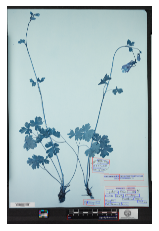

In [174]:
## draw new combined boxes
temp2 = imgs[this_img].copy()

for box in newboxes:
#     try:
#         l,r = box
#         x=l[0]
#         y=l[1]
#         w=r[0]-x
#         h=r[1]-y
#         cv2.rectangle(temp2,(x,y),(x+w,y+h),(255, 0,0),10)
#     except:
    cv2.drawContours(temp2,np.int0([box]),0,(255,0,0),2)


plt.imshow(temp2)
plt.axis('off')

In [176]:
cv2.imwrite("combinedboxes.png", temp2)

True